In [2]:
from pharynx_analysis import (
    pharynx_io as pio, 
    image_processing as ip, 
    experiment, 
    plots, 
    profile_processing,
    data_analysis as da
)

import xarray as xr
from pathlib import Path
from tqdm import tqdm_notebook
from scipy import signal
import seaborn as sns
from importlib import reload
import numpy as np
import logging
import pandas as pd
import matplotlib.pyplot as plt

reload(logging)
reload(experiment)
reload(pio)
reload(ip)
reload(plots)
reload(profile_processing)
reload(da)

# pd.set_option('display.height', 500)
pd.set_option('display.max_rows', 2000)

logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.DEBUG, datefmt='%I:%M:%S')

In [9]:
meta_dir = Path("/Users/sean/code/wormAnalysis/data/paired_ratio")

In [6]:
all_mvmt = da.load_all_movement(meta_dir).pivot_table(columns='region', values=['movement'], index=['pair', 'experiment', 'animal']).reset_index()

In [7]:
df = da.load_all_summaries(meta_dir)
df = df.reset_index(drop=True)
# df[df.experiment == '2017_02_22-HD233_SAY47']
df['total'] = df['anterior'] + df['posterior'] + df['sides_of_tip'] + df['tip']
df = df.pivot_table(index=['animal', 'experiment', 'strategy'], columns='pair').reset_index()
df = df.sort_values(['experiment', 'animal'])

df.index.rename('index', inplace=True)
df = df[df.strategy=='single_midline'].reset_index(drop=True)
df.index.rename('index', inplace=True)
df.head()

animal              experiment        strategy          410  \
pair                                                            0   
index                                                               
0          0  2017_02_22-HD233_SAY47  single_midline  7870.844336   
1          1  2017_02_22-HD233_SAY47  single_midline  8246.634465   
2          2  2017_02_22-HD233_SAY47  single_midline  9130.854713   
3          3  2017_02_22-HD233_SAY47  single_midline  8286.214881   
4          4  2017_02_22-HD233_SAY47  single_midline  8495.075566   

                            470              anterior              e  ...  \
pair             1            0            1        0  1           0  ...   
index                                                                 ...   
0      7920.495990  5527.920350  5534.442957        0  0 -270.665698  ...   
1      8632.961203  5702.474312  5967.811793        0  1 -270.068020  ...   
2      9089.399179  6687.374615  6572.134208        0  0 -272.191727  ...   
3      8356.184177  5576.142257  5573.285950        0  0 -269.174322  ...   
4      8322.516847  5689.122145  5586.420975        0  0 -268.784814  ...   

      posterior            r           sides_of_tip    tip    total     
pair          0  1         0         1            0  1   0  1     0  1  
index                                                                   
0             0  0  1.426809  1.435186            0  0   1  0     1  0  
1             0  1  1.450100  1.451914            1  1   0  1     1  4  
2             0  0  1.365797  1.383083            0  0   0  0     0  0  
3             0  0  1.491027  1.503232            0  0   0  0     0  0  
4             0  0  1.509562  1.508733            0  0   0  0     0  0  

[5 rows x 23 columns]

In [10]:
data_single = xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob('**/*single_midline/*.nc'))), dim='strain')
data_double = xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob('**/*double_midline*/*.nc'))), dim='strain')
data_smr = xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob('**/*single_midline_register/*.nc'))), dim='strain')
data_dmr = xr.concat((xr.load_dataarray(p) for p in sorted(meta_dir.glob('**/*double_midline_register/*.nc'))), dim='strain')

In [18]:
regions = {
    'pm3': [.07, .28],
    'pm4': [.33, .45],
    'pm5': [.53, .70],
    'pm6': [.80, .86],
    'pm7': [.88, .96],
}
scaled_regions = {
    region: np.int_(300 * np.asarray(regions[region]))
    for region in regions.keys()
}

In [11]:
df[(df['total'][0] == 0) & (df['total'][1] == 0)]

animal                experiment        strategy           410  \
pair                                                               0   
index                                                                  
2          2    2017_02_22-HD233_SAY47  single_midline   9130.854713   
3          3    2017_02_22-HD233_SAY47  single_midline   8286.214881   
4          4    2017_02_22-HD233_SAY47  single_midline   8495.075566   
7          7    2017_02_22-HD233_SAY47  single_midline   8254.053424   
9          9    2017_02_22-HD233_SAY47  single_midline  10223.341347   
13        13    2017_02_22-HD233_SAY47  single_midline   9538.776988   
14        14    2017_02_22-HD233_SAY47  single_midline   8529.057347   
15        15    2017_02_22-HD233_SAY47  single_midline   8827.962699   
16        16    2017_02_22-HD233_SAY47  single_midline   9043.265144   
20        20    2017_02_22-HD233_SAY47  single_midline   8969.427360   
24        24    2017_02_22-HD233_SAY47  single_midline   8556.049764   
25        25    2017_02_22-HD233_SAY47  single_midline   9591.618027   
26        26    2017_02_22-HD233_SAY47  single_midline   9043.832525   
27        27    2017_02_22-HD233_SAY47  single_midline   8190.462813   
28        28    2017_02_22-HD233_SAY47  single_midline   8593.535014   
30        30    2017_02_22-HD233_SAY47  single_midline   9339.510238   
33        33    2017_02_22-HD233_SAY47  single_midline   9701.831619   
34        34    2017_02_22-HD233_SAY47  single_midline   8732.875645   
37        37    2017_02_22-HD233_SAY47  single_midline   8435.920303   
38        38    2017_02_22-HD233_SAY47  single_midline   8897.840907   
39        39    2017_02_22-HD233_SAY47  single_midline   8984.805341   
40        40    2017_02_22-HD233_SAY47  single_midline   8613.664264   
41        41    2017_02_22-HD233_SAY47  single_midline   7975.679456   
44        44    2017_02_22-HD233_SAY47  single_midline   9505.708173   
45        45    2017_02_22-HD233_SAY47  single_midline   9506.747563   
46        46    2017_02_22-HD233_SAY47  single_midline   8455.913755   
47        47    2017_02_22-HD233_SAY47  single_midline   9603.180360   
48        48    2017_02_22-HD233_SAY47  single_midline   9440.297294   
49        49    2017_02_22-HD233_SAY47  single_midline   9444.059345   
51        51    2017_02_22-HD233_SAY47  single_midline   8921.580397   
53        53    2017_02_22-HD233_SAY47  single_midline   9609.634518   
54        54    2017_02_22-HD233_SAY47  single_midline   8420.326153   
55        55    2017_02_22-HD233_SAY47  single_midline   8211.411340   
56        56    2017_02_22-HD233_SAY47  single_midline   8772.004522   
57        57    2017_02_22-HD233_SAY47  single_midline   9713.408446   
59        59    2017_02_22-HD233_SAY47  single_midline   9946.279569   
60        60    2017_02_22-HD233_SAY47  single_midline   8987.836326   
61        61    2017_02_22-HD233_SAY47  single_midline   8567.233502   
63        63    2017_02_22-HD233_SAY47  single_midline   8301.829388   
64        64    2017_02_22-HD233_SAY47  single_midline   8349.850899   
65        65    2017_02_22-HD233_SAY47  single_midline   6449.093394   
66        66    2017_02_22-HD233_SAY47  single_midline   7735.619952   
67        67    2017_02_22-HD233_SAY47  single_midline   7860.547596   
70        70    2017_02_22-HD233_SAY47  single_midline   6956.586367   
71        71    2017_02_22-HD233_SAY47  single_midline   7356.208569   
74        74    2017_02_22-HD233_SAY47  single_midline   7718.753946   
75        75    2017_02_22-HD233_SAY47  single_midline   8983.412529   
76        76    2017_02_22-HD233_SAY47  single_midline   8754.005887   
77        77    2017_02_22-HD233_SAY47  single_midline   7952.962118   
78        78    2017_02_22-HD233_SAY47  single_midline   7868.400014   
79        79    2017_02_22-HD233_SAY47  single_midline   8523.648551   
80        80    2017_02_22-HD233_SAY47  single_midline   7695.133101   
81        81    2017_02_22-HD233_SAY47  single

In [12]:
sm_single = profile_processing.smooth_profile(data_single[:50], s=1e5)

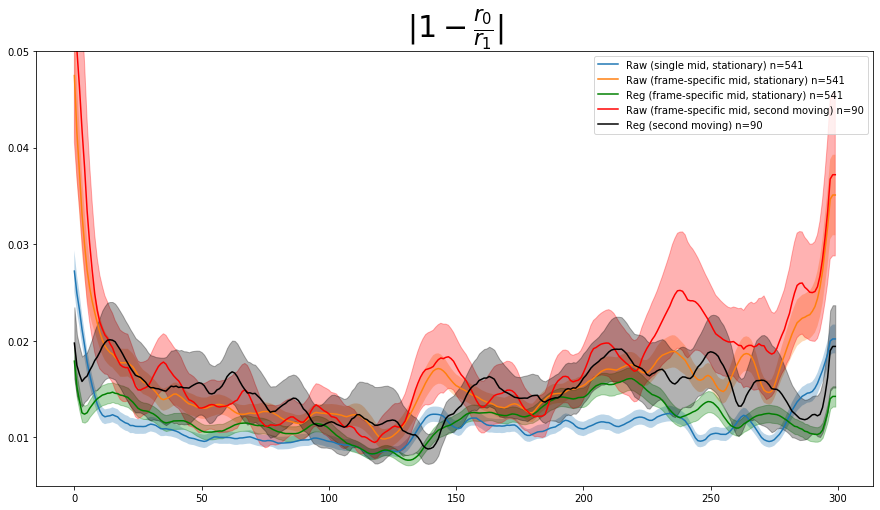

In [48]:
nomove = df[(df['total'][0] == 0) & (df['total'][1] == 0)].index.values

any_move = df[(df['total'][0] == 0) & (df['total'][1] > 0)].index.values

reg = 'anterior'
post_move = df[(df['total'][0] == 0) & (df[reg][1] > 0)].index.values

fig, ax0 = plt.subplots(1,1,figsize=(15,8))

plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_single)[nomove], ax=ax0, label=f'Raw (single mid, stationary) n={len(nomove)}')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_double)[nomove], ax=ax0, label=f'Raw (frame-specific mid, stationary) n={len(nomove)}')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_dmr)[nomove], ax=ax0, label=f'Reg (frame-specific mid, stationary) n={len(nomove)}', color='green')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_double)[any_move], ax=ax0, label=f'Raw (frame-specific mid, second moving) n={len(any_move)}', color='red')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_dmr)[any_move], ax=ax0, label=f'Reg (second moving) n={len(any_move)}', color='k')


ax0.legend(loc='upper right')
ax0.set_title(r'$|1 - \frac{r_0}{r_1}|}$', fontdict={'fontsize': 30});
# plots.add_regions_to_axis(regions=scaled_regions, ax=ax0)
ax0.set_ylim([0.005, 0.05]);

# plots.plot_profile_avg_with_bounds(
#     data_single.sel(wavelength='e', pair=0) - data_single.sel(wavelength='e', pair=0).mean(dim='position'), label='single', ax=ax1)
# plots.plot_profile_avg_with_bounds(
#     data_smr.sel(wavelength='e', pair=0) - data_smr.sel(wavelength='e', pair=0).mean(dim='position'), label='single reg', ax=ax1)
# ax1.legend()
# plots.add_regions_to_axis(ax1, ex.scaled_regions)
# plt.axhline(0)

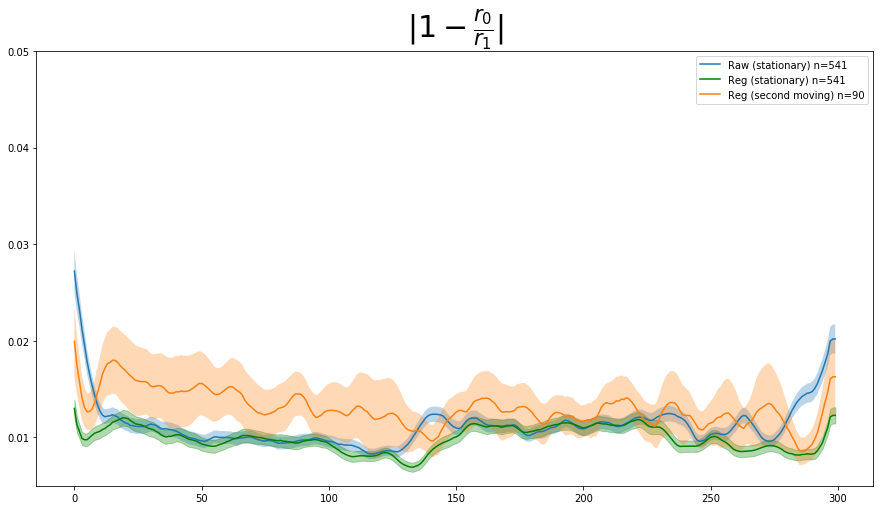

In [49]:
nomove = df[(df['total'][0] == 0) & (df['total'][1] == 0)].index.values

any_move = df[(df['total'][0] == 0) & (df['total'][1] > 0)].index.values

reg = 'anterior'
post_move = df[(df['total'][0] == 0) & (df[reg][1] > 0)].index.values

fig, ax0 = plt.subplots(1,1,figsize=(15,8))
plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_single)[nomove], ax=ax0, label=f'Raw (stationary) n={len(nomove)}')
plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_smr)[nomove], ax=ax0, label=f'Reg (stationary) n={len(nomove)}', color='green')

# plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_single)[any_move], ax=ax0, label=f'Raw (second moving) n={len(any_move)}', color='red')
# plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_single)[post_move], ax=ax0, label=f'single {reg} move n={len(any_move)}')


plots.plot_profile_avg_with_bounds(da.get_resid_rr(data_smr)[any_move], ax=ax0, label=f'Reg (second moving) n={len(any_move)}')


ax0.legend(loc='upper right')
ax0.set_title(r'$|1 - \frac{r_0}{r_1}|}$', fontdict={'fontsize': 30});
# plots.add_regions_to_axis(regions=scaled_regions, ax=ax0)
ax0.set_ylim([0.005, 0.05]);

# plots.plot_profile_avg_with_bounds(
#     data_single.sel(wavelength='e', pair=0) - data_single.sel(wavelength='e', pair=0).mean(dim='position'), label='single', ax=ax1)
# plots.plot_profile_avg_with_bounds(
#     data_smr.sel(wavelength='e', pair=0) - data_smr.sel(wavelength='e', pair=0).mean(dim='position'), label='single reg', ax=ax1)
# ax1.legend()
# plots.add_regions_to_axis(ax1, ex.scaled_regions)
# plt.axhline(0)

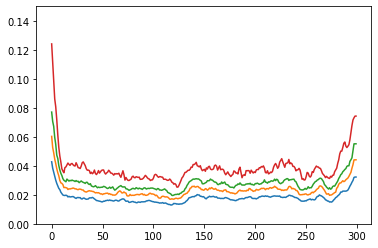

In [1082]:
plt.plot(np.percentile(da.get_resid_rr(data_single)[nomove], 80, axis=0))
plt.plot(np.percentile(da.get_resid_rr(data_single)[nomove], 90, axis=0))
plt.plot(np.percentile(da.get_resid_rr(data_single)[nomove], 95, axis=0))
plt.plot(np.percentile(da.get_resid_rr(data_single)[nomove], 99, axis=0))
# plt.plot(np.percentile(da.get_resid_rr(data_single)[any_move], 95, axis=0))
plt.ylim([0, 0.15]);

In [1267]:
sm_single = profile_processing.smooth_profile(data_single, s=1e7)

In [1378]:
imaging_scheme = "TL/470/410/470/410"
edir = '/Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47'
ex = experiment.PairExperiment(edir, imaging_scheme)
ex.load_images()

02:40:52 INFO:Starting full pipeline run for /Users/sean/code/wormAnalysis/data/paired_ratio/2017_02_22-HD233_SAY47
02:40:52 INFO:Loading Images


In [4]:
dxs = np.linspace(-.5,.5,4)
dys = np.zeros(len(dxs))
vecs = np.array(np.meshgrid(dxs,dys)).T.reshape(-1,2)
vecs

array([[-0.5       ,  0.        ],
       [-0.5       ,  0.        ],
       [-0.5       ,  0.        ],
       [-0.5       ,  0.        ],
       [-0.16666667,  0.        ],
       [-0.16666667,  0.        ],
       [-0.16666667,  0.        ],
       [-0.16666667,  0.        ],
       [ 0.16666667,  0.        ],
       [ 0.16666667,  0.        ],
       [ 0.16666667,  0.        ],
       [ 0.16666667,  0.        ],
       [ 0.5       ,  0.        ],
       [ 0.5       ,  0.        ],
       [ 0.5       ,  0.        ],
       [ 0.5       ,  0.        ]])

In [1873]:
rs = []
for i in range(all_rot_fl.strain.size):
    i410 = all_rot_fl.sel(wavelength='410', pair=0).isel(strain=i).values
    i470 = all_rot_fl.sel(wavelength='470', pair=0).isel(strain=i).values
    for j in range(vecs.shape[0]):
        rs.append(i410 / shift(i470, vecs[j]))

TypeError: can only concatenate xarray Dataset and DataArray objects, got <class 'numpy.ndarray'>

In [1883]:
tifffile.imsave('/Users/sean/Desktop/shifted_rs.tiff', rs.astype(np.float32))